In [38]:
import  pandas as pd, polars as pl
from    pathlib import Path
from    toolz import first

from    latent_action_models.data_exploration import cache

ACTION_PARQUET  = Path(first(cache.__path__)) / 'gta_frames_clean.parquet'
EVENT_PARQUET   = Path(first(cache.__path__)) / 'gta_events.parquet'

proc_df = pl.read_parquet(ACTION_PARQUET)

print(proc_df.columns)

['frame_idx', 'dx', 'dy', 'wheel', 'keypress_a', 'keypress_d', 'keypress_mouse1', 'keypress_mouse2', 'keypress_s', 'keypress_shift', 'keypress_w', 'video_path', 't_sec']


In [39]:
proc_df = pl.read_parquet(ACTION_PARQUET)
proc_df.head()

# TODO Mouse deltas should be normalized somehow, but 0 to 1 might not cut it?
# TODO Once all the above is sorted, cancel out antagonistic actions and filter out non WASD/SHIFT/CTRL actions
# TODO Then, check to see what's overrepresented and what is not, perhaps use some BPE for keypresses.

frame_idx,dx,dy,wheel,keypress_a,keypress_d,keypress_mouse1,keypress_mouse2,keypress_s,keypress_shift,keypress_w,video_path,t_sec
i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,str,f64
0,493.0,182.0,0.0,0,0,0,0,0,0,0,"""/mnt/data/shahbuland/video-pro…",0.0
1,1275.0,691.0,0.0,0,0,0,0,0,0,0,"""/mnt/data/shahbuland/video-pro…",0.033333
2,1462.0,635.0,0.0,0,0,0,0,0,0,0,"""/mnt/data/shahbuland/video-pro…",0.066667
3,1790.0,695.0,0.0,0,0,0,0,0,0,0,"""/mnt/data/shahbuland/video-pro…",0.1
4,1193.0,424.0,0.0,0,0,0,0,0,0,0,"""/mnt/data/shahbuland/video-pro…",0.133333


/mnt/data/shahbuland/video-proc-2/datasets/gta_nas/2025-06-03 21-35-09.mkv


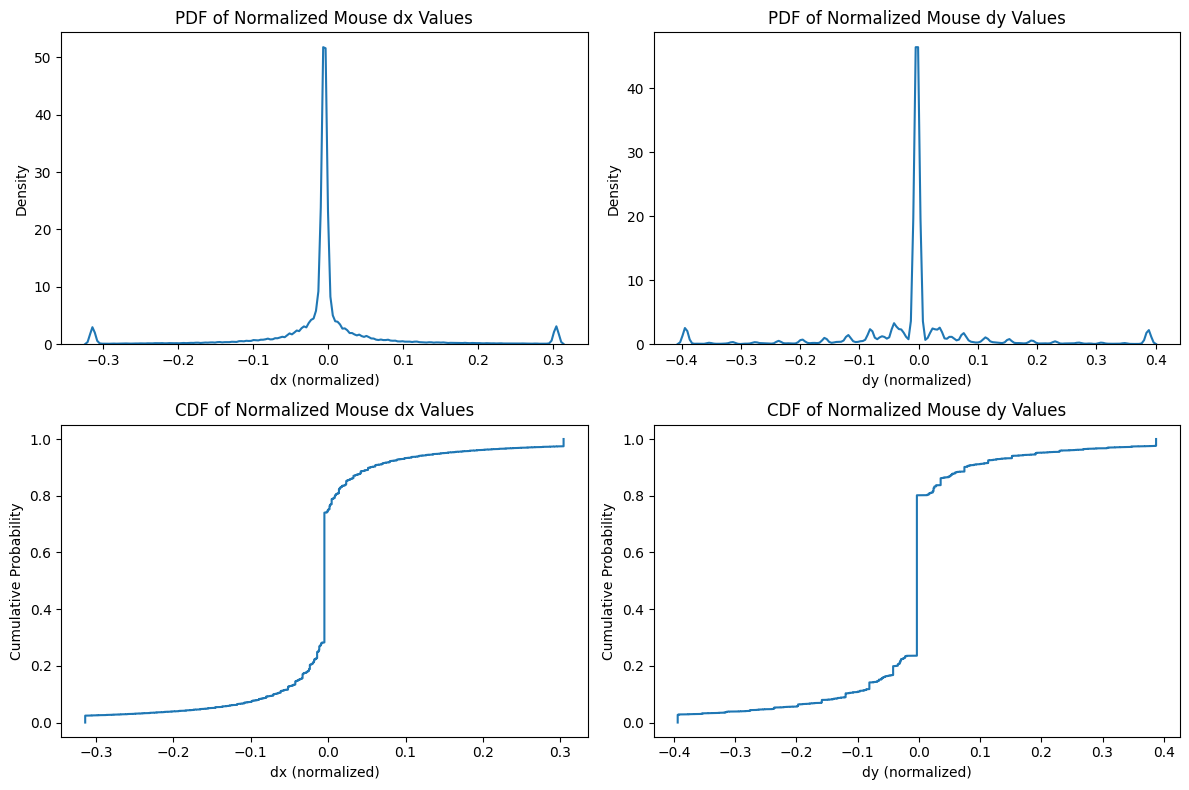

In [40]:
# Get the full rows with max/min dy values
dy_range = proc_df.filter(
    (pl.col("dy") == proc_df.select(pl.col("dy").max()).item()) |
    (pl.col("dy") == proc_df.select(pl.col("dy").min()).item())
)
print(dy_range['video_path'].unique()[0])
dy_range
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with four subplots in a 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
# Filter out extreme values for better visualization
# choose once, up-top
CLIP_Q = 0.95            # 95-th percentile of absolute deltas

# 1️⃣ find the cut values on |value|
cuts = (proc_df
        .select([
            pl.col("dx")   .abs().quantile(CLIP_Q).alias("dx_cut"),
            pl.col("dy")   .abs().quantile(CLIP_Q).alias("dy_cut"),
            pl.col("wheel").abs().quantile(CLIP_Q).alias("wheel_cut"),
        ])
        .to_dicts()[0])         # e.g. {'dx_cut': 742.0, 'dy_cut': 815.0, …}

# 2️⃣ clip symmetrically and normalize to [-1, 1]
proc_df = proc_df.with_columns([
    (pl.col("dx").clip(-cuts["dx_cut"], cuts["dx_cut"])   - proc_df["dx"].mean()) / proc_df["dx"].std(),
    (pl.col("dy").clip(-cuts["dy_cut"], cuts["dy_cut"])   - proc_df["dy"].mean()) / proc_df["dy"].std(),
])


# Plot PDF of dx values without extremes
sns.kdeplot(data=proc_df['dx'], ax=ax1)
ax1.set_title('PDF of Normalized Mouse dx Values')
ax1.set_xlabel('dx (normalized)')
ax1.set_ylabel('Density')

# Plot PDF of dy values without extremes
sns.kdeplot(data=proc_df['dy'], ax=ax2)
ax2.set_title('PDF of Normalized Mouse dy Values')
ax2.set_xlabel('dy (normalized)')
ax2.set_ylabel('Density')

# Plot CDF of dx values without extremes
dx_sorted = np.sort(proc_df['dx'].to_numpy())
dx_cdf = np.arange(1, len(dx_sorted) + 1) / len(dx_sorted)
ax3.plot(dx_sorted, dx_cdf)
ax3.set_title('CDF of Normalized Mouse dx Values')
ax3.set_xlabel('dx (normalized)')
ax3.set_ylabel('Cumulative Probability')

# Plot CDF of dy values without extremes
dy_sorted = np.sort(proc_df['dy'].to_numpy())
dy_cdf = np.arange(1, len(dy_sorted) + 1) / len(dy_sorted)
ax4.plot(dy_sorted, dy_cdf)
ax4.set_title('CDF of Normalized Mouse dy Values')
ax4.set_xlabel('dy (normalized)')
ax4.set_ylabel('Cumulative Probability')

plt.tight_layout()
plt.show()


In [41]:
df = proc_df.to_pandas()
raw_df = pl.read_parquet(EVENT_PARQUET).to_pandas()
df.tail()
# raw_df.tail()

,frame_idx,dx,dy,wheel,keypress_a,keypress_d,keypress_mouse1,keypress_mouse2,keypress_s,keypress_shift,keypress_w,video_path,t_sec
17026440,33285,-0.004852,-0.003091,0.0,0,0,0,0,0,0,0,/mnt/data/shahbuland/video-proc-2/datasets/gta...,1109.500000
17026441,33286,0.001781,-0.003091,0.0,0,0,0,0,0,0,0,/mnt/data/shahbuland/video-proc-2/datasets/gta...,1109.533333
17026442,33287,0.058159,0.053808,0.0,0,0,0,0,0,0,0,/mnt/data/shahbuland/video-proc-2/datasets/gta...,1109.566667
17026443,33288,0.058159,0.053808,0.0,0,0,0,0,0,0,0,/mnt/data/shahbuland/video-proc-2/datasets/gta...,1109.600000
17026444,33289,0.001781,0.025359,0.0,0,0,0,0,0,0,0,/mnt/data/shahbuland/video-proc-2/datasets/gta...,1109.633333


In [42]:
import pandas as pd

# ---------------------------------------------------------------------
# 0. starting point
# ---------------------------------------------------------------------
KEY_MAP = {
    "keypress_w":      "W",
    "keypress_a":      "A",
    "keypress_s":      "S",
    "keypress_d":      "D",
    "keypress_mouse1": "Mouse1",
    "keypress_mouse2": "Mouse2",
}
KEY_COLS = list(KEY_MAP)

# If your data is still a Polars frame, convert once:
# df = proc_df.to_pandas()
df = proc_df.to_pandas()


# ---------------------------------------------------------------------
# 1. build a 'combo' column
# ---------------------------------------------------------------------
def combo_row(r):
    keys = [KEY_MAP[c] for c in KEY_COLS if r[c]]
    return "+".join(keys) if keys else "Ø"

df["combo"] = df.apply(combo_row, axis=1)

# ---------------------------------------------------------------------
# 2. keep only the K most-frequent combos
# ---------------------------------------------------------------------
TOP_K = 12
top_combos = (
    df["combo"].value_counts()
      .nlargest(TOP_K)
      .index
)
df["combo_cat"] = df["combo"].where(df["combo"].isin(top_combos), "Other")

# df now has: …, combo, combo_cat


In [50]:
df.tail()['video_path']
# Filter to only show rows where at least one key is pressed
df[df[KEY_COLS].any(axis=1)][1050:1150]



,frame_idx,dx,dy,wheel,keypress_a,keypress_d,keypress_mouse1,keypress_mouse2,keypress_s,keypress_shift,keypress_w,video_path,t_sec,combo,combo_cat
29591,2278,-0.004852,-0.003091,0.0,1,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,75.933333,W+A,W+A
29592,2279,-0.004852,-0.003091,0.0,1,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,75.966667,W+A,W+A
29593,2280,-0.004852,-0.003091,0.0,1,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,76.000000,W+A,W+A
29594,2281,-0.004852,-0.003091,0.0,1,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,76.033333,W+A,W+A
29595,2282,-0.004852,-0.003091,0.0,1,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,76.066667,W+A,W+A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29686,2373,-0.004852,-0.003091,0.0,0,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,79.100000,W,W
29687,2374,-0.004852,-0.003091,0.0,0,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,79.133333,W,W
29688,2375,-0.004852,-0.003091,0.0,0,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,79.166667,W,W
29689,2376,-0.004852,-0.003091,0.0,0,0,0,0,0,0,1,/mnt/data/shahbuland/video-proc-2/datasets/gta...,79.200000,W,W
